In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import pymc3 as py
import matplotlib.pyplot as plt
import psycopg2 as ps

In [2]:
def view(query):
    conn = ps.connect("host='redshift.service.aws2' port='5439' dbname='production' user='ggiorcelli' password='Gg1234590'")
    cur = conn.cursor()
    cur.execute(query)  
    data=cur.fetchall()
    col_names = []
    for elt in cur.description:
        col_names.append(elt[0])
     
    df = pd.DataFrame(data, columns=col_names)
    return df
    conn.close()

In [12]:
query = "select DISTINCT l.f_date::date as day, count(distinct l.k_lead_id) leads from main.f_dealer_lead l where l.f_date::date between '2016-10-01' and '2017-03-15' group by 1 order by 1"

In [13]:
df = pd.DataFrame(view(query))
df.head()

,day,leads
0,2016-10-01,11308
1,2016-10-02,9258
2,2016-10-03,10668
3,2016-10-04,10325
4,2016-10-05,9827


In [5]:
def get_delta(field):
    list=[0]
    for i in range(1,len(field)):
        delta_2 = field[i]-field[i-1]
        list.append(delta_2)
    return(list)
        
#delta2 = get_delta(df['leads'])   
#delta2

In [14]:
results = { 'day': df['day'],
         'leads' : df['leads'],
         'delta' : get_delta(df['leads'])
          }

df1 = pd.DataFrame.from_dict(results)[['day','leads', 'delta']]
df1.head()

,day,leads,delta
0,2016-10-01,11308,0
1,2016-10-02,9258,-2050
2,2016-10-03,10668,1410
3,2016-10-04,10325,-343
4,2016-10-05,9827,-498


In [36]:
delta2 = get_delta(df['leads']) 
delta2

[0, -2, 3, -4, 3, 1, 6, -7, 2, 4]

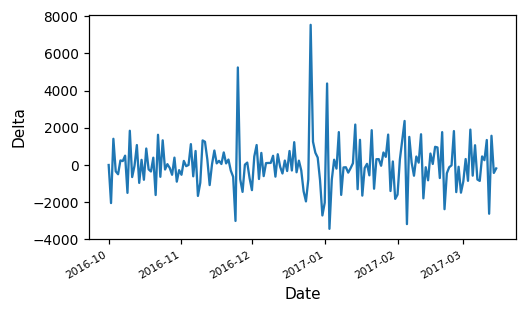

In [15]:
import matplotlib

#x = [dt.datetime.strptime(d,'%y/%m/%d').date() for d in results['day']]
x = results['day']
y = results['delta']

fig = plt.figure(figsize=(5,3), dpi=110)

plt.plot(x,y)
plt.ylabel('Delta')
plt.xlabel('Date')

fig.autofmt_xdate()
matplotlib.rc('xtick',labelsize=7)
matplotlib.rc('ytick',labelsize=9)

plt.show()

In [16]:
from pymc3 import Exponential, StudentT, Deterministic
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk
from pymc3 import Model, Normal, HalfNormal

with Model() as leads_model:

    nu = Exponential('nu', 1./10, testval=5.)

    sigma = Exponential('sigma', 1./.02, testval=.1)

    s = GaussianRandomWalk('s', sigma**-2, shape=len(df1['delta']))

    volatility_process = Deterministic('volatility_process', exp(-2*s))

    r = StudentT('r', nu, lam=1/volatility_process, observed=(df1['delta']))

In [17]:
from pymc3 import variational

import scipy
with leads_model:
    trace = py.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -1,656.2: 100%|██████████| 200000/200000 [00:23<00:00, 8463.86it/s]
Finished [100%]: Average ELBO = -1,629.9
100%|██████████| 2000/2000 [02:08<00:00, 15.52it/s]


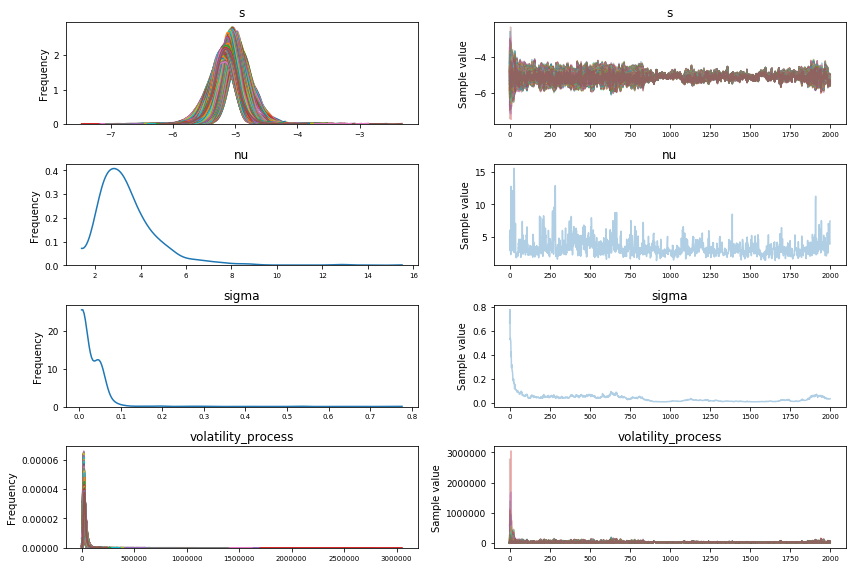

In [10]:
py.traceplot(trace)
plt.show()

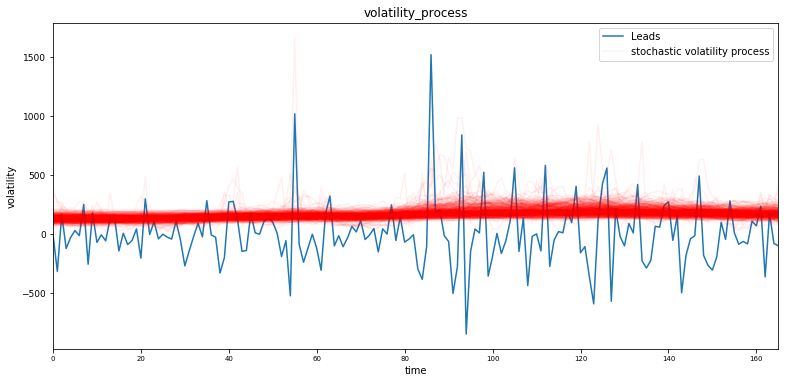

In [11]:
fig, ax = plt.subplots(figsize=(13, 6))
df1['delta'].plot(ax=ax)
ax.plot(df1['delta'].index, 1/np.exp(trace['s',::5].T), 'r', alpha=.06);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['Leads', 'stochastic volatility process'])

plt.show()